Partie 2: Classification de séries temporelles avec CNN et CNN-LSTM sur ECG5000
1. Chargement et prétraitement des données

In [7]:
!pip install numpy torch pandas scikit-learn matplotlib 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

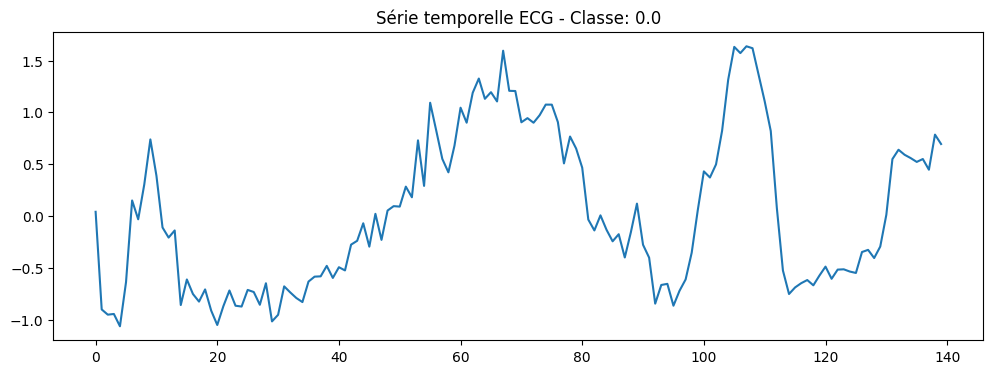

In [9]:
# Chargement du dataset ECG5000 depuis l'archive UCR
# Note: Vous devrez télécharger le dataset depuis https://www.timeseriesclassification.com/description.php?Dataset=ECG5000
# et l'extraire dans le dossier 'data'

def load_ucr_dataset(path):
    data = pd.read_csv(path, header=None, sep='\s+')
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:].values
    return X, y

# Chemins vers les données (à adapter selon votre structure de fichiers)
train_path = 'data/ECG5000/ECG5000_TRAIN.txt'
test_path = 'data/ECG5000/ECG5000_TEST.txt'

X_train, y_train = load_ucr_dataset(train_path)
X_test, y_test = load_ucr_dataset(test_path)

y_train = y_train - 1
y_test = y_test - 1

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion en tenseurs PyTorch et redimensionnement pour CNN
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Ajout d'une dimension de canal
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

# Création des DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualisation d'une série temporelle
plt.figure(figsize=(12, 4))
plt.plot(X_train[0])
plt.title(f'Série temporelle ECG - Classe: {y_train[0]}')
plt.show()

2. Définition des architectures

In [10]:
# Afficher les valeurs uniques des labels
print("Valeurs uniques dans y_train:", np.unique(y_train))
print("Valeurs uniques dans y_test:", np.unique(y_test))

# Vérifier le nombre de classes
num_classes = len(np.unique(y_train))
print(f"Nombre de classes détecté: {num_classes}")

Valeurs uniques dans y_train: [0. 1. 2. 3. 4.]
Valeurs uniques dans y_test: [0. 1. 2. 3. 4.]
Nombre de classes détecté: 5


In [11]:
# Modèle CNN pour séries temporelles
class CNN_TS(nn.Module):
    def __init__(self, input_channels=1, num_classes=num_classes):
        super(CNN_TS, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        # Calcul automatique de la taille avant les couches fully connected
        self._to_linear = None
        self._calculate_conv_output_size(X_train_tensor)
        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def _calculate_conv_output_size(self, sample_input):
        # Passe un échantillon à travers les couches conv pour calculer la taille
        with torch.no_grad():
            x = self.pool(F.relu(self.conv1(sample_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            self._to_linear = x.view(x.size(0), -1).shape[1]
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Modèle hybride CNN-LSTM
class CNN_LSTM_TS(nn.Module):
    def __init__(self, input_channels=1, num_classes=num_classes):
        super(CNN_LSTM_TS, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(64 * 2, num_classes)  # *2 car bidirectional
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Partie CNN
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Préparation pour LSTM (conv1d sort (batch, channels, length))
        x = x.permute(0, 2, 1)  # (batch, length, channels)
        
        # Partie LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # On prend seulement le dernier pas de temps
        
        # Classification
        x = self.dropout(x)
        x = self.fc1(x)
        return x

3. Entraînement et évaluation

In [12]:
def train_and_evaluate(model, train_loader, test_loader, model_name, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Entraînement
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'{model_name} - Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}')
    
    # Évaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'{model_name} - Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Création d'un échantillon factice pour calculer la taille
sample_input = X_train_tensor[:1]  # Prend juste le premier échantillon

# Initialisation des modèles
cnn_model = CNN_TS()
cnn_lstm_model = CNN_LSTM_TS()

# Entraînement et évaluation
print("Training CNN model...")
cnn_accuracy = train_and_evaluate(cnn_model, train_loader, test_loader, "CNN", num_epochs=20)

print("\nTraining CNN-LSTM model...")
cnn_lstm_accuracy = train_and_evaluate(cnn_lstm_model, train_loader, test_loader, "CNN-LSTM", num_epochs=20)

# Comparaison des performances
print(f"\nPerformance comparison:")
print(f"CNN: {cnn_accuracy:.2f}%")
print(f"CNN-LSTM: {cnn_lstm_accuracy:.2f}%")
print(f"Difference: {cnn_lstm_accuracy - cnn_accuracy:.2f}%")

Training CNN model...
CNN - Epoch 1, Loss: 0.6779
CNN - Epoch 2, Loss: 0.2970
CNN - Epoch 3, Loss: 0.2640
CNN - Epoch 4, Loss: 0.1931
CNN - Epoch 5, Loss: 0.1629
CNN - Epoch 6, Loss: 0.1698
CNN - Epoch 7, Loss: 0.1513
CNN - Epoch 8, Loss: 0.1382
CNN - Epoch 9, Loss: 0.1225
CNN - Epoch 10, Loss: 0.1134
CNN - Epoch 11, Loss: 0.1096
CNN - Epoch 12, Loss: 0.1017
CNN - Epoch 13, Loss: 0.1101
CNN - Epoch 14, Loss: 0.0969
CNN - Epoch 15, Loss: 0.0848
CNN - Epoch 16, Loss: 0.0807
CNN - Epoch 17, Loss: 0.0892
CNN - Epoch 18, Loss: 0.1037
CNN - Epoch 19, Loss: 0.0818
CNN - Epoch 20, Loss: 0.0724
CNN - Test Accuracy: 94.16%

Training CNN-LSTM model...
CNN-LSTM - Epoch 1, Loss: 1.1190
CNN-LSTM - Epoch 2, Loss: 0.4724
CNN-LSTM - Epoch 3, Loss: 0.4168
CNN-LSTM - Epoch 4, Loss: 0.3701
CNN-LSTM - Epoch 5, Loss: 0.3607
CNN-LSTM - Epoch 6, Loss: 0.3223
CNN-LSTM - Epoch 7, Loss: 0.3221
CNN-LSTM - Epoch 8, Loss: 0.3297
CNN-LSTM - Epoch 9, Loss: 0.3179
CNN-LSTM - Epoch 10, Loss: 0.3055
CNN-LSTM - Epoch 11,